<a href="https://colab.research.google.com/github/chaerin314/2021-Agricultural-Product-Price-Prediction-AI-Contest/blob/main/code_4_rsw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m pip install --user --upgrade pip

     |████████████████████████████████| 1.7 MB 7.4 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
pip install numpy==1.19.5

In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import os

#  데이터 조작 및 시각화에 필요한 툴들 import
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 40
pd.options.display.max_columns = 10
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# 모델링 알고리즘
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Model selection

# Evaluation metrics
#regression용
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# classification용
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#텐서연산을 위한 백엔드
from keras import backend as K

In [ ]:
#결과값 고정을 위한 랜덤값 고정 =>실제 결과값 낼때는 풀기

import random as rn
import tensorflow as tf
import numpy as  np
import os

seed_num=0
np.random.seed(seed_num)
rn.seed(seed_num)
os.environ['PYTHONHASHSEED'] = '0'
tf.compat.v1.set_random_seed(
    seed_num
)


In [ ]:
tf.random.set_seed(
    seed_num
)

In [ ]:
def non_feature_engineering(raw):
    if 'datetime' in raw.columns:
        print()
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)
        #<dtype오류!>
    # if raw.index.dtype != 'int64':
    #     raw.reset_index(drop=False, inplace=True)
    raw = raw.asfreq('D', method='ffill')
    #전에껄로 채웠음
    raw_nfe = raw.copy()
    return raw_nfe
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    raw.set_index('DateTime', inplace=True)
    #<dtype오류!>
    # if raw.index.dtype != 'int64':
    #     raw.reset_index(drop=False, inplace=True)
    raw = raw.asfreq('D', method='ffill')
    
    #과정2
    result = sm.tsa.seasonal_decompose(raw['배추_가격(원/kg)'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw.columns:
        if 'count_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)


    
    Y_count_Week = raw[['배추_가격(원/kg)']].rolling(7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    Y_count_Month = raw[['배추_가격(원/kg)']].rolling(7*4).mean()
    Y_count_Month.fillna(method='ffill', inplace=True)
    Y_count_Month.fillna(method='bfill', inplace=True)
    Y_count_Month.columns = ['count_Month']
    if 'count_Week' not in raw.columns:
        raw = pd.concat([raw, Y_count_Week], axis=1)
    if 'count_Month' not in raw.columns:
        raw = pd.concat([raw, Y_count_Month], axis=1)

    Y_diff = raw[['배추_가격(원/kg)']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw.columns:
        raw = pd.concat([raw, Y_diff], axis=1)

    raw['Year'] = raw.datetime.dt.year
    raw['Quater'] = raw.datetime.dt.quarter
    raw['Quater_ver2'] = raw['Quater'] + (raw.Year - raw.Year.min()) * 4
    raw['Month'] = raw.datetime.dt.month
    raw['Day'] = raw.datetime.dt.day
    raw['Hour'] = raw.datetime.dt.hour
    raw['DayofWeek'] = raw.datetime.dt.dayofweek

    raw['count_lag1'] = raw['배추_가격(원/kg)'].shift(1)
    raw['count_lag2'] = raw['배추_가격(원/kg)'].shift(2)
    raw['count_lag1'].fillna(method='bfill', inplace=True)
    raw['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quater'], 
                                                 prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw['Quater']
    raw_fe = raw.copy()
    return raw_fe

def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')


### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    
    return Score, Residual
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)

def root_mean_squared_error(target, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - target)))

'''def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        Y_Data['RowNum'] = Y_Data.reset_index().index

        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)


        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])


    Stationarity_adf = stationarity_adf_test(Y_Data, Target_name)
    Stationarity_kpss = stationarity_kpss_test(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
    return Score

'''

'def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):\n    for x in Target_name:\n        Target_name = x\n    X_Data = X_Data.loc[Y_Data.index]\n\n    if graph_on == True:\n        Y_Data[\'RowNum\'] = Y_Data.reset_index().index\n\n        sns.set(palette="muted", color_codes=True, font_scale=2)\n        sns.lmplot(x=\'RowNum\', y=Target_name, data=Y_Data, fit_reg=\'True\', size=5.2, aspect=2, ci=99, sharey=True)\n        del Y_Data[\'RowNum\']\n\n        # Normal Distribution Analysis\n        figure, axes = plt.subplots(figsize=(12,8))\n        sns.distplot(Y_Data[Target_name], norm_hist=\'True\', fit=stats.norm, ax=axes)\n\n\n        length = int(len(Y_Data[Target_name])/10)\n        figure, axes = plt.subplots(1, 4, figsize=(12,3))\n        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])\n        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])\n        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])\n        pd.plotting.lag_plot(

In [ ]:
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_felm = X_test.copy()
    for col in target:
        X_test_felm[col] = Y_test.shift(1).values
        X_test_felm[col].fillna(method='bfill', inplace=True)
        X_test_felm[col] = Y_test.shift(2).values
        X_test_felm[col].fillna(method='bfill', inplace=True)
    return X_test_felm

def feature_engineering_scaling(scaler, X_train, X_test):
    
    scaler = scaler
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train), 
                               index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), 
                               index=X_test.index, columns=X_test.columns)
    return X_train_scaling, X_test_scaling

def stationarity_adf_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf

def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss

def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_test(Y_Data, Target_name)
    Stationarity_kpss = stationarity_kpss_test(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
    return Score
# error_analysis(Resid_tr_reg1[1:], ['Error'], X_train, graph_on=True)

In [ ]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = "/content/drive/MyDrive/SEDL: 농산물 가격 대회/products/public_data/train.csv"
raw_all = pd.read_csv(data)
raw_all.rename(columns = {'date' : 'datetime'}, inplace = True)
raw_all=raw_all.drop(raw_all[(raw_all.iloc[:, 2:].sum(axis=1)==0)].index)

In [ ]:
raw_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1486 entries, 1 to 1732
Data columns (total 44 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   datetime        1486 non-null   object 
 1   요일              1486 non-null   object 
 2   배추_거래량(kg)      1486 non-null   float64
 3   배추_가격(원/kg)     1486 non-null   float64
 4   무_거래량(kg)       1486 non-null   float64
 5   무_가격(원/kg)      1486 non-null   float64
 6   양파_거래량(kg)      1486 non-null   float64
 7   양파_가격(원/kg)     1486 non-null   float64
 8   건고추_거래량(kg)     1486 non-null   float64
 9   건고추_가격(원/kg)    1486 non-null   float64
 10  마늘_거래량(kg)      1486 non-null   float64
 11  마늘_가격(원/kg)     1486 non-null   float64
 12  대파_거래량(kg)      1486 non-null   float64
 13  대파_가격(원/kg)     1486 non-null   float64
 14  얼갈이배추_거래량(kg)   1486 non-null   float64
 15  얼갈이배추_가격(원/kg)  1486 non-null   float64
 16  양배추_거래량(kg)     1486 non-null   float64
 17  양배추_가격(원/kg)    1486 non-null   f

In [ ]:
raw_all.describe()

,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),...,애호박_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
count,"1,486.00","1,486.00","1,486.00","1,486.00","1,486.00",...,"1,486.00","1,486.00","1,486.00","1,486.00","1,486.00"
mean,"1,298,026.75",696.37,"1,486,163.07",572.31,"1,931,989.01",...,"1,855.26","138,028.66","3,748.82","7,802.27","8,151.50"
std,"760,282.49",356.43,"516,969.89",240.19,"722,353.97",...,870.75,"261,086.59","1,841.43","26,073.11","7,981.42"
min,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00
25%,"895,263.10",450.00,"1,212,214.35",370.25,"1,528,831.12",...,"1,191.25","2,296.50","2,631.25",0.00,0.00
50%,"1,135,622.80",658.00,"1,444,523.50",510.00,"1,799,550.45",...,"1,734.50","6,769.30","3,579.50",487.00,"8,449.00"
75%,"1,449,343.77",833.00,"1,718,741.73",748.00,"2,257,841.17",...,"2,357.75","128,408.10","4,528.50","3,760.00","12,715.25"
max,"5,210,215.00","5,000.00","3,859,745.90","1,360.00","5,024,753.40",...,"6,778.00","1,490,337.00","25,000.00","382,263.40","40,000.00"


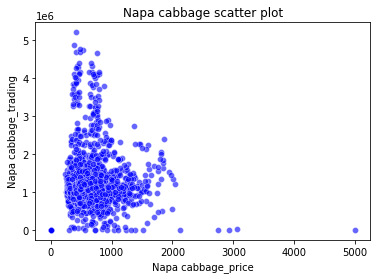

In [ ]:
# scatter plot 1
sns.scatterplot(data=raw_all, x='배추_가격(원/kg)', y='배추_거래량(kg)', markers='o', color='blue', alpha=0.6)
plt.xlabel('Napa cabbage_price')
plt.ylabel('Napa cabbage_trading')
plt.title('Napa cabbage scatter plot')
plt.show()

In [ ]:
#공분산 계산
x = raw_all['배추_가격(원/kg)']
y = raw_all['배추_거래량(kg)']

print(np.cov(x,y)[0,1])

#상관계수
print(np.corrcoef(x,y)[0,1])

-27886838.600767024
-0.10290841949957358


In [ ]:
raw_fe = feature_engineering(raw_all)

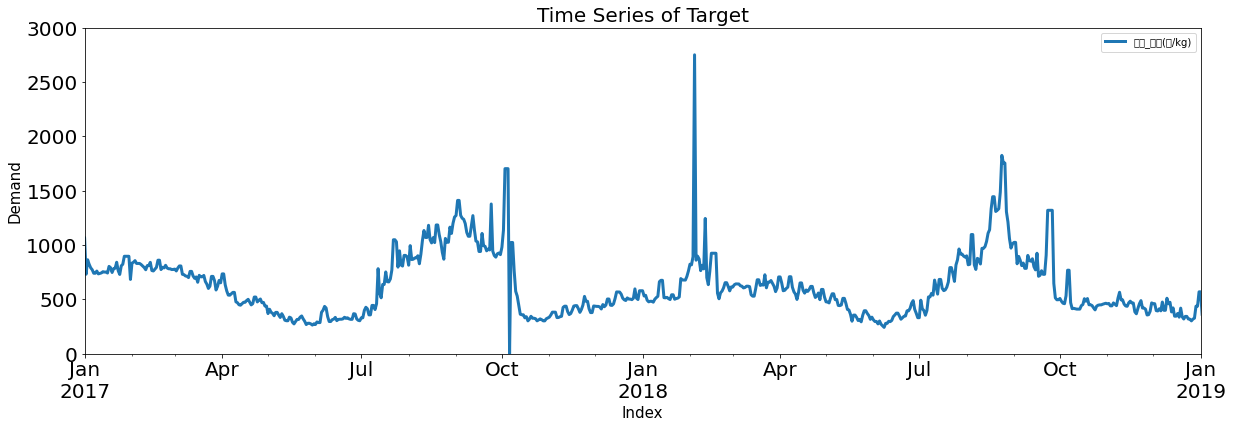

In [ ]:
# line plot of Y
raw_fe[['배추_가격(원/kg)']].plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                              xlim=('2017-01-01', '2019-01-01'), ylim=(0,3000))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Demand', fontsize=15)
plt.show()

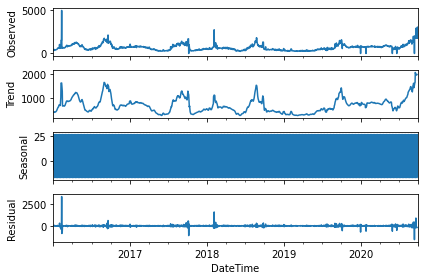

In [ ]:
# split data as trend + seasonal + residual
sm.tsa.seasonal_decompose(raw_fe['배추_가격(원/kg)'], model='additive').plot()
plt.show()

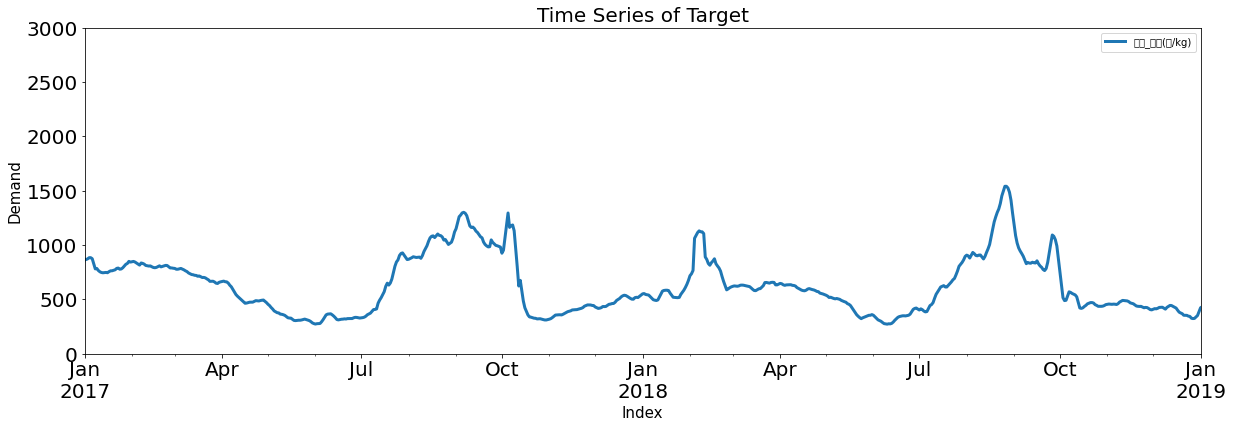

In [ ]:
# plot of moving average values using rolling function
raw_fe[['배추_가격(원/kg)']].rolling(7).mean().plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                             xlim=('2017-01-01', '2019-01-01'), ylim=(0,3000))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Demand', fontsize=15)
plt.show()

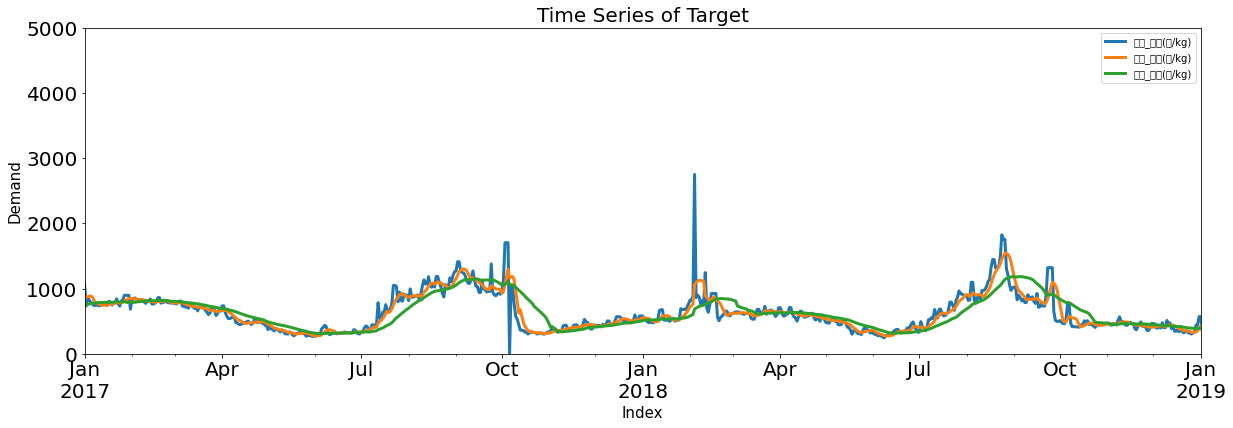

In [ ]:
pd.concat([raw_fe[['배추_가격(원/kg)']],
           raw_fe[['배추_가격(원/kg)']].rolling(7).mean(),
           raw_fe[['배추_가격(원/kg)']].rolling(4*7).mean()], axis=1).plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                                                  xlim=('2017-01-01', '2019-01-01'), ylim=(0,5000))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Demand', fontsize=15)
plt.show()

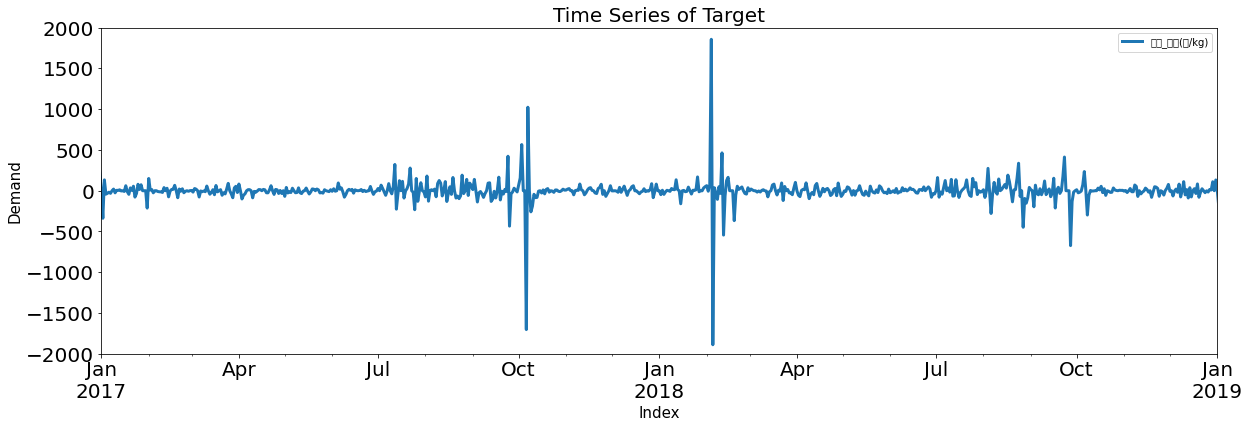

In [ ]:
raw_fe[['배추_가격(원/kg)']].diff().plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                 xlim=('2017-01-01', '2019-01-01'), ylim=(-2000,2000))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Demand', fontsize=15)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


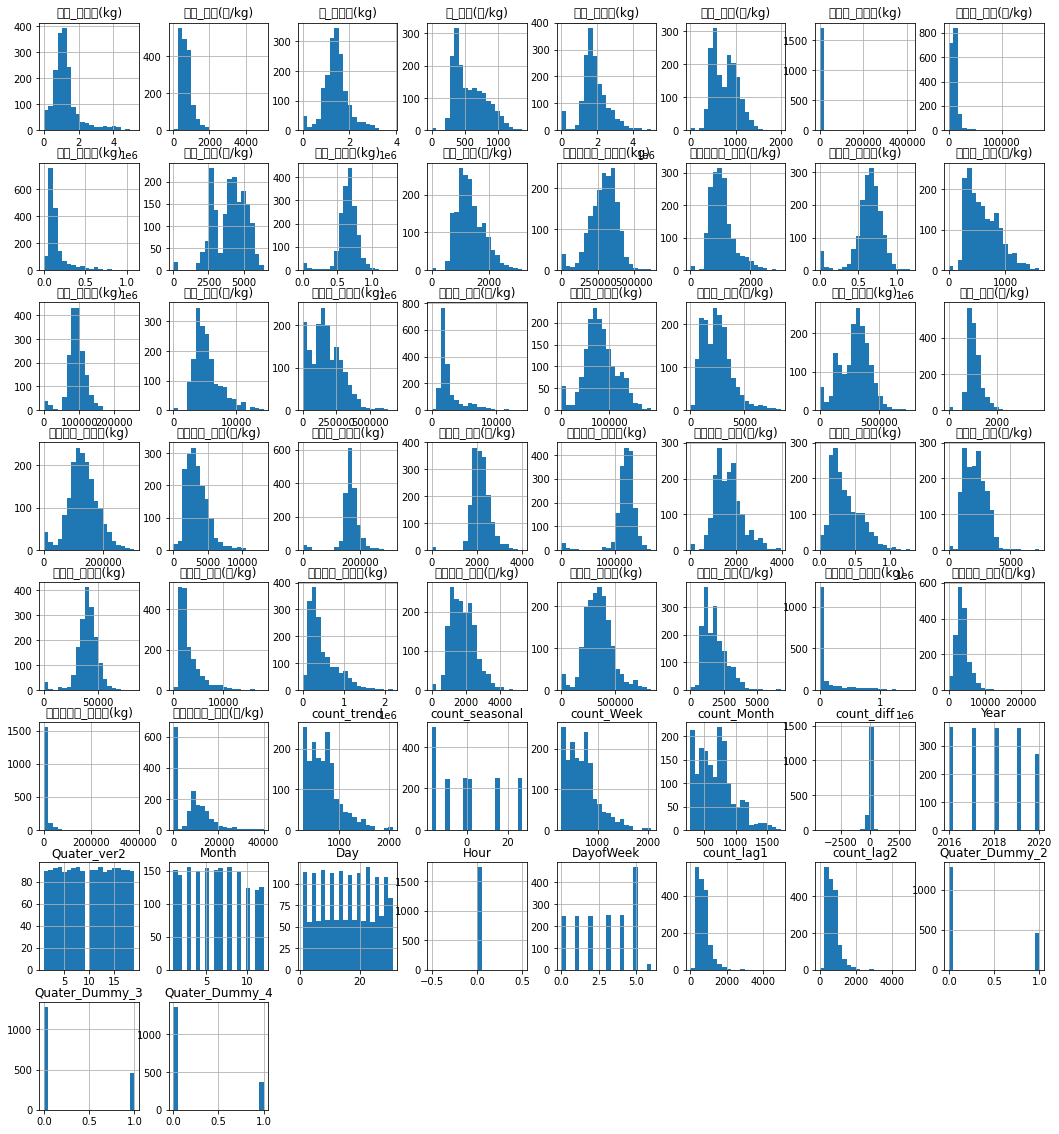

In [ ]:
raw_fe.hist(bins=20, grid=True, figsize=(18,20))
plt.show()

In [ ]:
raw_fe.head(10)

,datetime,요일,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),...,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
DateTime,,,,,,,,,,,
2016-01-02,2016-01-02,토요일,"80,860.00",329.00,"80,272.00",...,329.00,329.00,0,0,0
2016-01-03,2016-01-02,토요일,"80,860.00",329.00,"80,272.00",...,329.00,329.00,0,0,0
2016-01-04,2016-01-04,월요일,"1,422,742.50",478.00,"1,699,653.70",...,329.00,329.00,0,0,0
2016-01-05,2016-01-05,화요일,"1,167,241.00",442.00,"1,423,482.30",...,478.00,329.00,0,0,0
2016-01-06,2016-01-06,수요일,"1,045,507.50",442.00,"1,904,372.10",...,442.00,478.00,0,0,0
2016-01-07,2016-01-07,목요일,"1,039,925.00",448.00,"1,438,990.20",...,442.00,442.00,0,0,0
2016-01-08,2016-01-08,금요일,"942,655.00",420.00,"1,563,537.80",...,448.00,442.00,0,0,0
2016-01-09,2016-01-09,토요일,"689,121.00",389.00,"1,723,983.90",...,420.00,448.00,0,0,0
2016-01-10,2016-01-09,토요일,"689,121.00",389.00,"1,723,983.90",...,389.00,420.00,0,0,0


In [ ]:
raw_fe.shape

(1732, 60)

In [ ]:
raw_fe.head(10)

,datetime,요일,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),...,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
DateTime,,,,,,,,,,,
2016-01-02,2016-01-02,토요일,"80,860.00",329.00,"80,272.00",...,329.00,329.00,0,0,0
2016-01-03,2016-01-02,토요일,"80,860.00",329.00,"80,272.00",...,329.00,329.00,0,0,0
2016-01-04,2016-01-04,월요일,"1,422,742.50",478.00,"1,699,653.70",...,329.00,329.00,0,0,0
2016-01-05,2016-01-05,화요일,"1,167,241.00",442.00,"1,423,482.30",...,478.00,329.00,0,0,0
2016-01-06,2016-01-06,수요일,"1,045,507.50",442.00,"1,904,372.10",...,442.00,478.00,0,0,0
2016-01-07,2016-01-07,목요일,"1,039,925.00",448.00,"1,438,990.20",...,442.00,442.00,0,0,0
2016-01-08,2016-01-08,금요일,"942,655.00",420.00,"1,563,537.80",...,448.00,442.00,0,0,0
2016-01-09,2016-01-09,토요일,"689,121.00",389.00,"1,723,983.90",...,420.00,448.00,0,0,0
2016-01-10,2016-01-09,토요일,"689,121.00",389.00,"1,723,983.90",...,389.00,420.00,0,0,0


In [ ]:
raw_fe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1732 entries, 2016-01-02 to 2020-09-28
Freq: D
Data columns (total 60 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        1732 non-null   datetime64[ns]
 1   요일              1732 non-null   object        
 2   배추_거래량(kg)      1732 non-null   float64       
 3   배추_가격(원/kg)     1732 non-null   float64       
 4   무_거래량(kg)       1732 non-null   float64       
 5   무_가격(원/kg)      1732 non-null   float64       
 6   양파_거래량(kg)      1732 non-null   float64       
 7   양파_가격(원/kg)     1732 non-null   float64       
 8   건고추_거래량(kg)     1732 non-null   float64       
 9   건고추_가격(원/kg)    1732 non-null   float64       
 10  마늘_거래량(kg)      1732 non-null   float64       
 11  마늘_가격(원/kg)     1732 non-null   float64       
 12  대파_거래량(kg)      1732 non-null   float64       
 13  대파_가격(원/kg)     1732 non-null   float64       
 14  얼갈이배추_거래량(kg)   1732 non-null 

In [ ]:
raw_fe.describe()

,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),...,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
count,"1,732.00","1,732.00","1,732.00","1,732.00","1,732.00",...,"1,732.00","1,732.00","1,732.00","1,732.00","1,732.00"
mean,"1,239,890.26",700.32,"1,430,720.17",571.27,"1,870,839.38",...,699.43,697.85,0.26,0.26,0.21
std,"779,229.49",352.99,"536,403.76",239.86,"745,324.44",...,351.98,347.47,0.44,0.44,0.41
min,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00
25%,"812,434.95",451.75,"1,134,890.12",369.00,"1,471,811.33",...,451.00,451.00,0.00,0.00,0.00
50%,"1,087,812.60",662.00,"1,408,262.25",506.50,"1,755,269.75",...,661.50,661.00,0.00,0.00,0.00
75%,"1,416,888.62",841.25,"1,682,650.50",747.00,"2,218,581.65",...,841.00,840.25,1.00,1.00,0.00
max,"5,210,215.00","5,000.00","3,859,745.90","1,360.00","5,024,753.40",...,"5,000.00","5,000.00",1.00,1.00,1.00


In [ ]:
raw_fe.tail(10)

,datetime,요일,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),...,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
DateTime,,,,,,,,,,,
2020-09-19,2020-09-19,토요일,"1,346,091.40","1,812.00","1,546,003.50",...,"1,839.00","1,983.00",0,1,0
2020-09-20,2020-09-20,일요일,"1,959.00","2,925.00","4,240.00",...,"1,812.00","1,839.00",0,1,0
2020-09-21,2020-09-21,월요일,"2,046,286.30","1,813.00","2,340,632.60",...,"2,925.00","1,812.00",0,1,0
2020-09-22,2020-09-22,화요일,"1,757,465.60","1,838.00","2,159,123.60",...,"1,813.00","2,925.00",0,1,0
2020-09-23,2020-09-23,수요일,"2,007,471.30","1,807.00","2,106,715.40",...,"1,838.00","1,813.00",0,1,0
2020-09-24,2020-09-24,목요일,"1,856,965.00","1,839.00","2,055,640.00",...,"1,807.00","1,838.00",0,1,0
2020-09-25,2020-09-25,금요일,"1,880,095.50","1,789.00","1,879,261.00",...,"1,839.00","1,807.00",0,1,0
2020-09-26,2020-09-26,토요일,"1,661,090.90","1,760.00","1,709,385.70",...,"1,789.00","1,839.00",0,1,0
2020-09-27,2020-09-27,일요일,"25,396.00","3,066.00","38,222.00",...,"1,760.00","1,789.00",0,1,0


Train_size: (730, 60) Test_size: (1002, 60)
X_train: (730, 4) Y_train: (730, 1)
X_test: (1002, 4) Y_test: (1002, 1)
X_train: (723, 7, 6) Y_train: (723, 1)
X_test: (995, 7, 6) Y_test: (995, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 128)            69120     
                                                                 
 dropout (Dropout)           (None, 7, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 256)            394240    
                                                                 
 dropout_1 (Dropout)         (None, 7, 256)            0         
                                                                 
 lstm_2 (LSTM)               (None, 7, 128)            197120    
                                                              

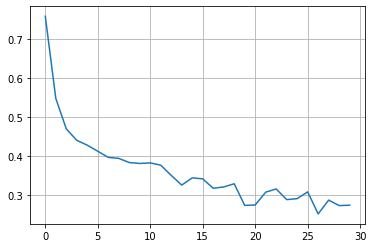

32/32 [==============================] - 1s 20ms/step - loss: 2.8524e-08


,MAE,MSE,MAPE
Train,64.24,"67,415.01",inf
Test,63.76,"17,054.88",inf


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


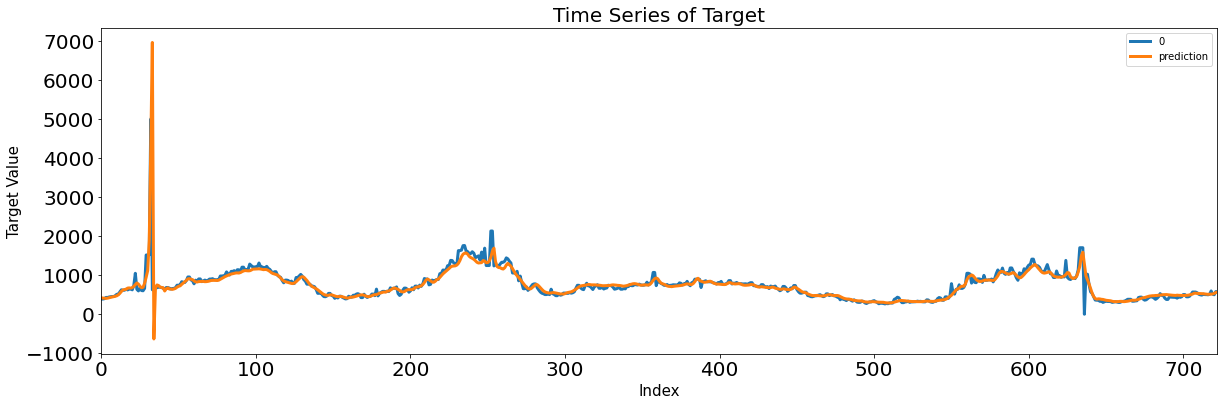

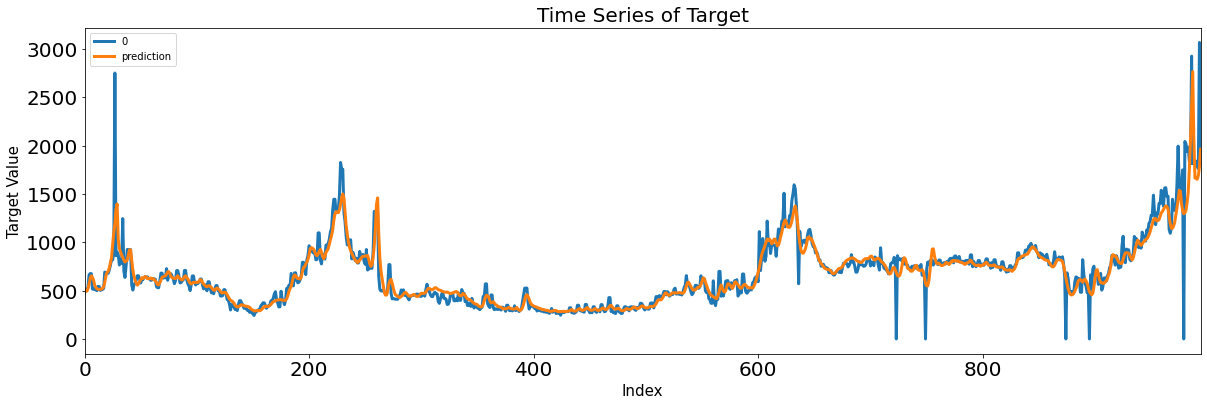

In [ ]:


#feature engineering으로 바뀜-sm decomposion사용

y_col = ['배추_가격(원/kg)']
X_col = ["배추_거래량(kg)", 'count_lag1', 'count_lag2', "count_trend"]
X_train_fe, X_test_fe, y_train_fe, y_test_fe = datasplit_ts(raw_fe, y_col, X_col, '2018-01-01')

target=["price_lag1", "price_lag2"]
X_train_fe = feature_engineering_lag_modified(y_train_fe, X_train_fe, target)
X_test_fe = feature_engineering_lag_modified(y_test_fe, X_test_fe, target)
###############X_test는 lag_modified 하지 않아야함!!(바꾸기)

            # Parameters
            # preprocessing.MinMaxScaler()
                # preprocessing.StandardScaler()
                # preprocessing.RobustScaler()
                # preprocessing.Normalizer()
scaler_X_tr = preprocessing.RobustScaler()
scaler_y_tr = preprocessing.RobustScaler()
sequence = 7
batch_size = 50 #바꿔보기
epoch = 30 #30으로 바꿔보기
verbose = 1
dropout_ratio = 0.05


X_train_scaled = scaler_X_tr.fit_transform(X_train_fe)
y_train_scaled = scaler_y_tr.fit_transform(y_train_fe)
X_test_scaled = scaler_X_tr.transform(X_test_fe)
y_test_scaled = scaler_y_tr.transform(y_test_fe)
    
            ## X / Y Split-오늘 할 일: sequence 이해하고 바꿔보기
X_train, y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    y_train.append(np.ravel(y_train_scaled[index + sequence:index + sequence + 1]))
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    y_test.append(np.ravel(y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, y_test = np.array(X_test), np.array(y_test) 


X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', y_test.shape)



# LSTM/ sequence뭐 쓸지 

model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio, seed=0)) 
model.add(LSTM(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio, seed=0)) 
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio, seed=0)) 
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio, seed=0)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss=root_mean_squared_error)
model.summary()
model_fit = model.fit(X_train, y_train, 
                              batch_size=batch_size, epochs=epoch,
                              verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

    # evaluation!
result = model.evaluate(X_test, y_test_pred)


if scaler_y_tr != []:
    y_train = scaler_y_tr.inverse_transform(y_train)
    y_train_pred = scaler_y_tr.inverse_transform(y_train_pred)
    y_test = scaler_y_tr.inverse_transform(y_test)
    y_test_pred = scaler_y_tr.inverse_transform(y_test_pred)
Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(y_train), y_train_pred.flatten(), 
                                                      pd.DataFrame(y_test), y_test_pred.flatten(), graph_on=True)
display(Score_LSTM)

#모든 작물에서 돌아가게 바꿔보기'''

In [ ]:
print(y_test_pred)

[[ 502.9514 ]
 [ 494.77606]
 [ 494.43875]
 [ 518.8323 ]
 [ 570.3091 ]
 [ 628.15063]
 [ 653.3125 ]
 [ 637.65405]
 [ 608.00073]
 [ 558.3943 ]
 [ 533.8078 ]
 [ 519.40344]
 [ 514.16956]
 [ 512.8545 ]
 [ 514.0734 ]
 [ 515.10913]
 [ 523.59515]
 [ 540.8547 ]
 [ 586.37   ]
 [ 651.5607 ]
 [ 687.37177]
 [ 699.8887 ]
 [ 735.00507]
 [ 786.23   ]
 [ 840.16125]
 [ 977.83527]
 [1098.7848 ]
 [1191.6763 ]
 [1346.3079 ]
 [1395.6702 ]
 [1026.589  ]
 [ 933.4532 ]
 [ 901.427  ]
 [ 869.29236]
 [ 844.3507 ]
 [ 814.8757 ]
 [ 796.0504 ]
 [ 806.0014 ]
 [ 814.6856 ]
 [ 866.7273 ]
 [ 922.4251 ]
 [ 922.1526 ]
 [ 818.7622 ]
 [ 708.59607]
 [ 650.4991 ]
 [ 606.8291 ]
 [ 574.4377 ]
 [ 557.22595]
 [ 569.5826 ]
 [ 593.1701 ]
 [ 613.609  ]
 [ 633.329  ]
 [ 624.99615]
 [ 634.00507]
 [ 645.5958 ]
 [ 641.92505]
 [ 623.7139 ]
 [ 623.7221 ]
 [ 625.27844]
 [ 630.30505]
 [ 618.50134]
 [ 623.1797 ]
 [ 618.0835 ]
 [ 599.68695]
 [ 585.7091 ]
 [ 560.9389 ]
 [ 559.14996]
 [ 581.2707 ]
 [ 610.86945]
 [ 637.69635]
 [ 642.2142 ]
 [ 647